## Final Experiment for BVNS

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import string

import numpy as np
from plot_utils import plot_two_solutions
import matplotlib.pyplot as plt 

from ioutils import parse_input
from ioutils import parse_solutions
from utils import get_distance_matrix
from utils import get_discount_matrix
from utils import allocate_paths
from utils import get_nodes
from utils import get_total_cost
from utils import get_flow_from_paths
import cplex_utils
import graph_utils as graph_utils

from ioutils import get_comparison_table_file_name
from utils import get_latest_commit_id
from utils import get_comparison_table

import pandas as pd

In [2]:
DATASET = 'AP'
INPUT_DIRECTORY = "./data/AP/generated/"
SOLUTIONS_FILE ='/home/ubuntu/VNS_for_UMApHMP/data/AP/Solutions-UMApHMP.txt'

In [3]:
from vns import get_initial_solution_random
from vns import get_initial_solution_robust
from vns import get_initial_solution_circle

from vns import local_search_best_improvement
from vns import local_search_first_improvement


from vns import basic_VNS

from utils import NEIGHBOURHOOD_TYPES

from ioutils import get_comparison_table_file_name
from utils import get_latest_commit_id

In [4]:
NUMBER_OF_PROBLEMS = 45
OUTPUT_FILE_NAME = get_comparison_table_file_name('final_comparison', str(NUMBER_OF_PROBLEMS), get_latest_commit_id())

In [5]:
def best_ls(solution, neighbourhood_type, use_c):
    return local_search_best_improvement(solution, neighbourhood_type, use_c)

def first_ls(solution, neighbourhood_type, use_c):
    return local_search_first_improvement(solution, neighbourhood_type, use_c)

def random_init(n, p, distances, nodes_coor):
    return get_initial_solution_random(n, p, distances, nodes_coor)

def grane_init(n, p, distances, nodes_coor):
    return get_initial_solution_robust(n, p, distances, nodes_coor)

def uglovi_init(n, p, distances, nodes_coor):
    return get_initial_solution_circle(n, p, distances, nodes_coor)


In [6]:
# ------- algorithm parameters --------
shaking_intensity = [0, 0.5]
initializations = [random_init, grane_init, uglovi_init]
local_searches = [best_ls, first_ls]
max_iters = [3]
kmax_options = [1,2,3]

In [7]:
methods = []
names = []

for shake_int in shaking_intensity:
        for ls in local_searches:
            for kmax in kmax_options:
                for max_iter in max_iters:
                    methods.append(lambda problem, initial_solution: basic_VNS(problem, initial_solution=initial_solution, diversification_param=shake_int, local_search=ls, neighbourhood_types=NEIGHBOURHOOD_TYPES[:kmax], max_iter=max_iter))
                    names.append(" ".join(["BVNS", "shake="+str(shake_int), ls.__name__, "kmax="+str(kmax), "max_iter="+str(max_iter)]))


In [8]:
len(names)

12

In [9]:
names[:5]

['BVNS shake=0 best_ls kmax=1 max_iter=3',
 'BVNS shake=0 best_ls kmax=2 max_iter=3',
 'BVNS shake=0 best_ls kmax=3 max_iter=3',
 'BVNS shake=0 first_ls kmax=1 max_iter=3',
 'BVNS shake=0 first_ls kmax=2 max_iter=3']

In [10]:
comparison_table = get_comparison_table(
    methods,
    names,
    DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE,
    from_problem=0,
    to_problems=NUMBER_OF_PROBLEMS,
    initializations=initializations,
    display_nan=False)
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')
# comparison_table = pd.read_csv("output/basic_VNS_final_comparison_35_d42a72836976d0d8abf612afa150b58ce819c49f.csv", index_col=0)

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [24:55<00:00, 33.22s/it] 


In [11]:
comparison_table.head(NUMBER_OF_PROBLEMS+1)

,BVNS shake=0 best_ls kmax=1 max_iter=3 random_init - deviation (%),BVNS shake=0 best_ls kmax=1 max_iter=3 random_init - time (s),BVNS shake=0 best_ls kmax=1 max_iter=3 grane_init - deviation (%),BVNS shake=0 best_ls kmax=1 max_iter=3 grane_init - time (s),BVNS shake=0 best_ls kmax=1 max_iter=3 uglovi_init - deviation (%),BVNS shake=0 best_ls kmax=1 max_iter=3 uglovi_init - time (s),BVNS shake=0 best_ls kmax=2 max_iter=3 random_init - deviation (%),BVNS shake=0 best_ls kmax=2 max_iter=3 random_init - time (s),BVNS shake=0 best_ls kmax=2 max_iter=3 grane_init - deviation (%),BVNS shake=0 best_ls kmax=2 max_iter=3 grane_init - time (s),...,BVNS shake=0.5 first_ls kmax=2 max_iter=3 grane_init - deviation (%),BVNS shake=0.5 first_ls kmax=2 max_iter=3 grane_init - time (s),BVNS shake=0.5 first_ls kmax=2 max_iter=3 uglovi_init - deviation (%),BVNS shake=0.5 first_ls kmax=2 max_iter=3 uglovi_init - time (s),BVNS shake=0.5 first_ls kmax=3 max_iter=3 random_init - deviation (%),BVNS shake=0.5 first_ls kmax=3 max_iter=3 random_init - time (s),BVNS shake=0.5 first_ls kmax=3 max_iter=3 grane_init - deviation (%),BVNS shake=0.5 first_ls kmax=3 max_iter=3 grane_init - time (s),BVNS shake=0.5 first_ls kmax=3 max_iter=3 uglovi_init - deviation (%),BVNS shake=0.5 first_ls kmax=3 max_iter=3 uglovi_init - time (s)
10.2,0.000000,0.01,0.000000,0.010000,0.000000,0.010,0.000000,0.010000,0.000000,0.010000,...,0.00,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000
10.3,0.000000,0.01,0.000000,0.010000,0.000000,0.010,0.000000,0.010000,0.000000,0.010000,...,0.00,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000
10.4,0.000000,0.01,0.000000,0.010000,0.000000,0.010,0.000000,0.010000,0.000000,0.010000,...,0.00,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000
10.5,0.000000,0.01,0.000000,0.010000,0.000000,0.010,0.000000,0.010000,0.000000,0.010000,...,0.00,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000
20.2,0.000000,0.02,0.000000,0.020000,0.000000,0.020,0.000000,0.020000,0.000000,0.020000,...,0.00,0.020000,0.000000,0.020000,0.000000,0.020000,0.000000,0.020000,0.000000,0.020000
20.3,0.000000,0.04,0.560000,0.030000,0.560000,0.030,0.560000,0.040000,0.000000,0.040000,...,0.56,0.030000,0.000000,0.040000,0.000000,0.040000,0.560000,0.030000,0.000000,0.040000
20.4,0.000000,0.05,0.000000,0.050000,0.000000,0.060,0.000000,0.050000,0.000000,0.050000,...,0.00,0.050000,0.000000,0.050000,0.000000,0.050000,0.000000,0.050000,0.000000,0.050000
20.5,0.000000,0.08,0.000000,0.070000,0.000000,0.060,0.000000,0.060000,0.000000,0.070000,...,0.00,0.070000,0.000000,0.070000,0.650000,0.050000,0.000000,0.070000,0.000000,0.060000
25.2,0.000000,0.04,0.000000,0.040000,0.000000,0.030,0.000000,0.040000,0.000000,0.040000,...,0.00,0.040000,0.000000,0.040000,0.000000,0.050000,0.000000,0.030000,0.000000,0.040000
25.3,0.000000,0.06,0.000000,0.060000,0.000000,0.050,0.000000,0.060000,0.000000,0.050000,...,0.00,0.050000,0.000000,0.050000,0.000000,0.080000,0.000000,0.050000,0.000000,0.060000


In [12]:
def get_all_columns_with_similar_value(df, value):
    return df.loc[:, abs(df.iloc[-1] - value) < 0.02].columns

In [13]:
time_table = comparison_table[comparison_table.columns[1::2]]
deviation_table = comparison_table[comparison_table.columns[::2]]

In [14]:
# min deviation

best_method_per_dev = deviation_table.idxmin(axis=1)[-1]
worst_method_per_dev = deviation_table.idxmax(axis=1)[-1]

best_dev_value = comparison_table[best_method_per_dev]['mean']
worst_dev_value = comparison_table[worst_method_per_dev]['mean']


best_method_per_dev, best_dev_value

('BVNS shake=0 best_ls kmax=2 max_iter=3 uglovi_init - deviation (%)', 0.0)

In [15]:
worst_method_per_dev, worst_dev_value

('BVNS shake=0 best_ls kmax=2 max_iter=3 random_init - deviation (%)',
 0.09964285714285714)

In [16]:
# min time

best_method_per_time = time_table.idxmin(axis=1)[-1]
worst_method_per_time = time_table.idxmax(axis=1)[-1]

best_time_value = comparison_table[best_method_per_time]['mean']
worst_time_value = comparison_table[worst_method_per_time]['mean']

best_method_per_time, best_time_value

('BVNS shake=0 best_ls kmax=1 max_iter=3 uglovi_init - time (s)',
 1.3450000000000002)

In [17]:
worst_method_per_time, worst_time_value

('BVNS shake=0.5 best_ls kmax=1 max_iter=3 uglovi_init - time (s)',
 1.6635714285714285)

In [18]:
# ------- sort all columns based on mean ----------

In [19]:
ten_best_per_time = time_table.sort_values(by='mean', axis=1).iloc[:, : 10]
ten_best_per_time

,BVNS shake=0 best_ls kmax=1 max_iter=3 uglovi_init - time (s),BVNS shake=0.5 best_ls kmax=2 max_iter=3 grane_init - time (s),BVNS shake=0 first_ls kmax=3 max_iter=3 grane_init - time (s),BVNS shake=0.5 best_ls kmax=3 max_iter=3 random_init - time (s),BVNS shake=0.5 first_ls kmax=2 max_iter=3 random_init - time (s),BVNS shake=0 best_ls kmax=2 max_iter=3 grane_init - time (s),BVNS shake=0.5 first_ls kmax=1 max_iter=3 grane_init - time (s),BVNS shake=0 first_ls kmax=2 max_iter=3 grane_init - time (s),BVNS shake=0.5 best_ls kmax=1 max_iter=3 grane_init - time (s),BVNS shake=0.5 best_ls kmax=3 max_iter=3 grane_init - time (s)
10.2,0.010,0.010000,0.010000,0.010,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
10.3,0.010,0.010000,0.010000,0.010,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
10.4,0.010,0.010000,0.010000,0.010,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
10.5,0.010,0.010000,0.010000,0.010,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
20.2,0.020,0.020000,0.020000,0.020,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
20.3,0.030,0.040000,0.040000,0.040,0.040000,0.040000,0.040000,0.030000,0.030000,0.030000
20.4,0.060,0.060000,0.050000,0.050,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
20.5,0.060,0.060000,0.060000,0.080,0.080000,0.070000,0.060000,0.070000,0.070000,0.090000
25.2,0.030,0.040000,0.040000,0.040,0.040000,0.040000,0.030000,0.040000,0.030000,0.030000
25.3,0.050,0.060000,0.050000,0.090,0.050000,0.050000,0.060000,0.060000,0.070000,0.060000


In [20]:
time_table.sort_values(by='mean', axis=1).to_csv("bvns_best_per_time.csv", index_label='problem')


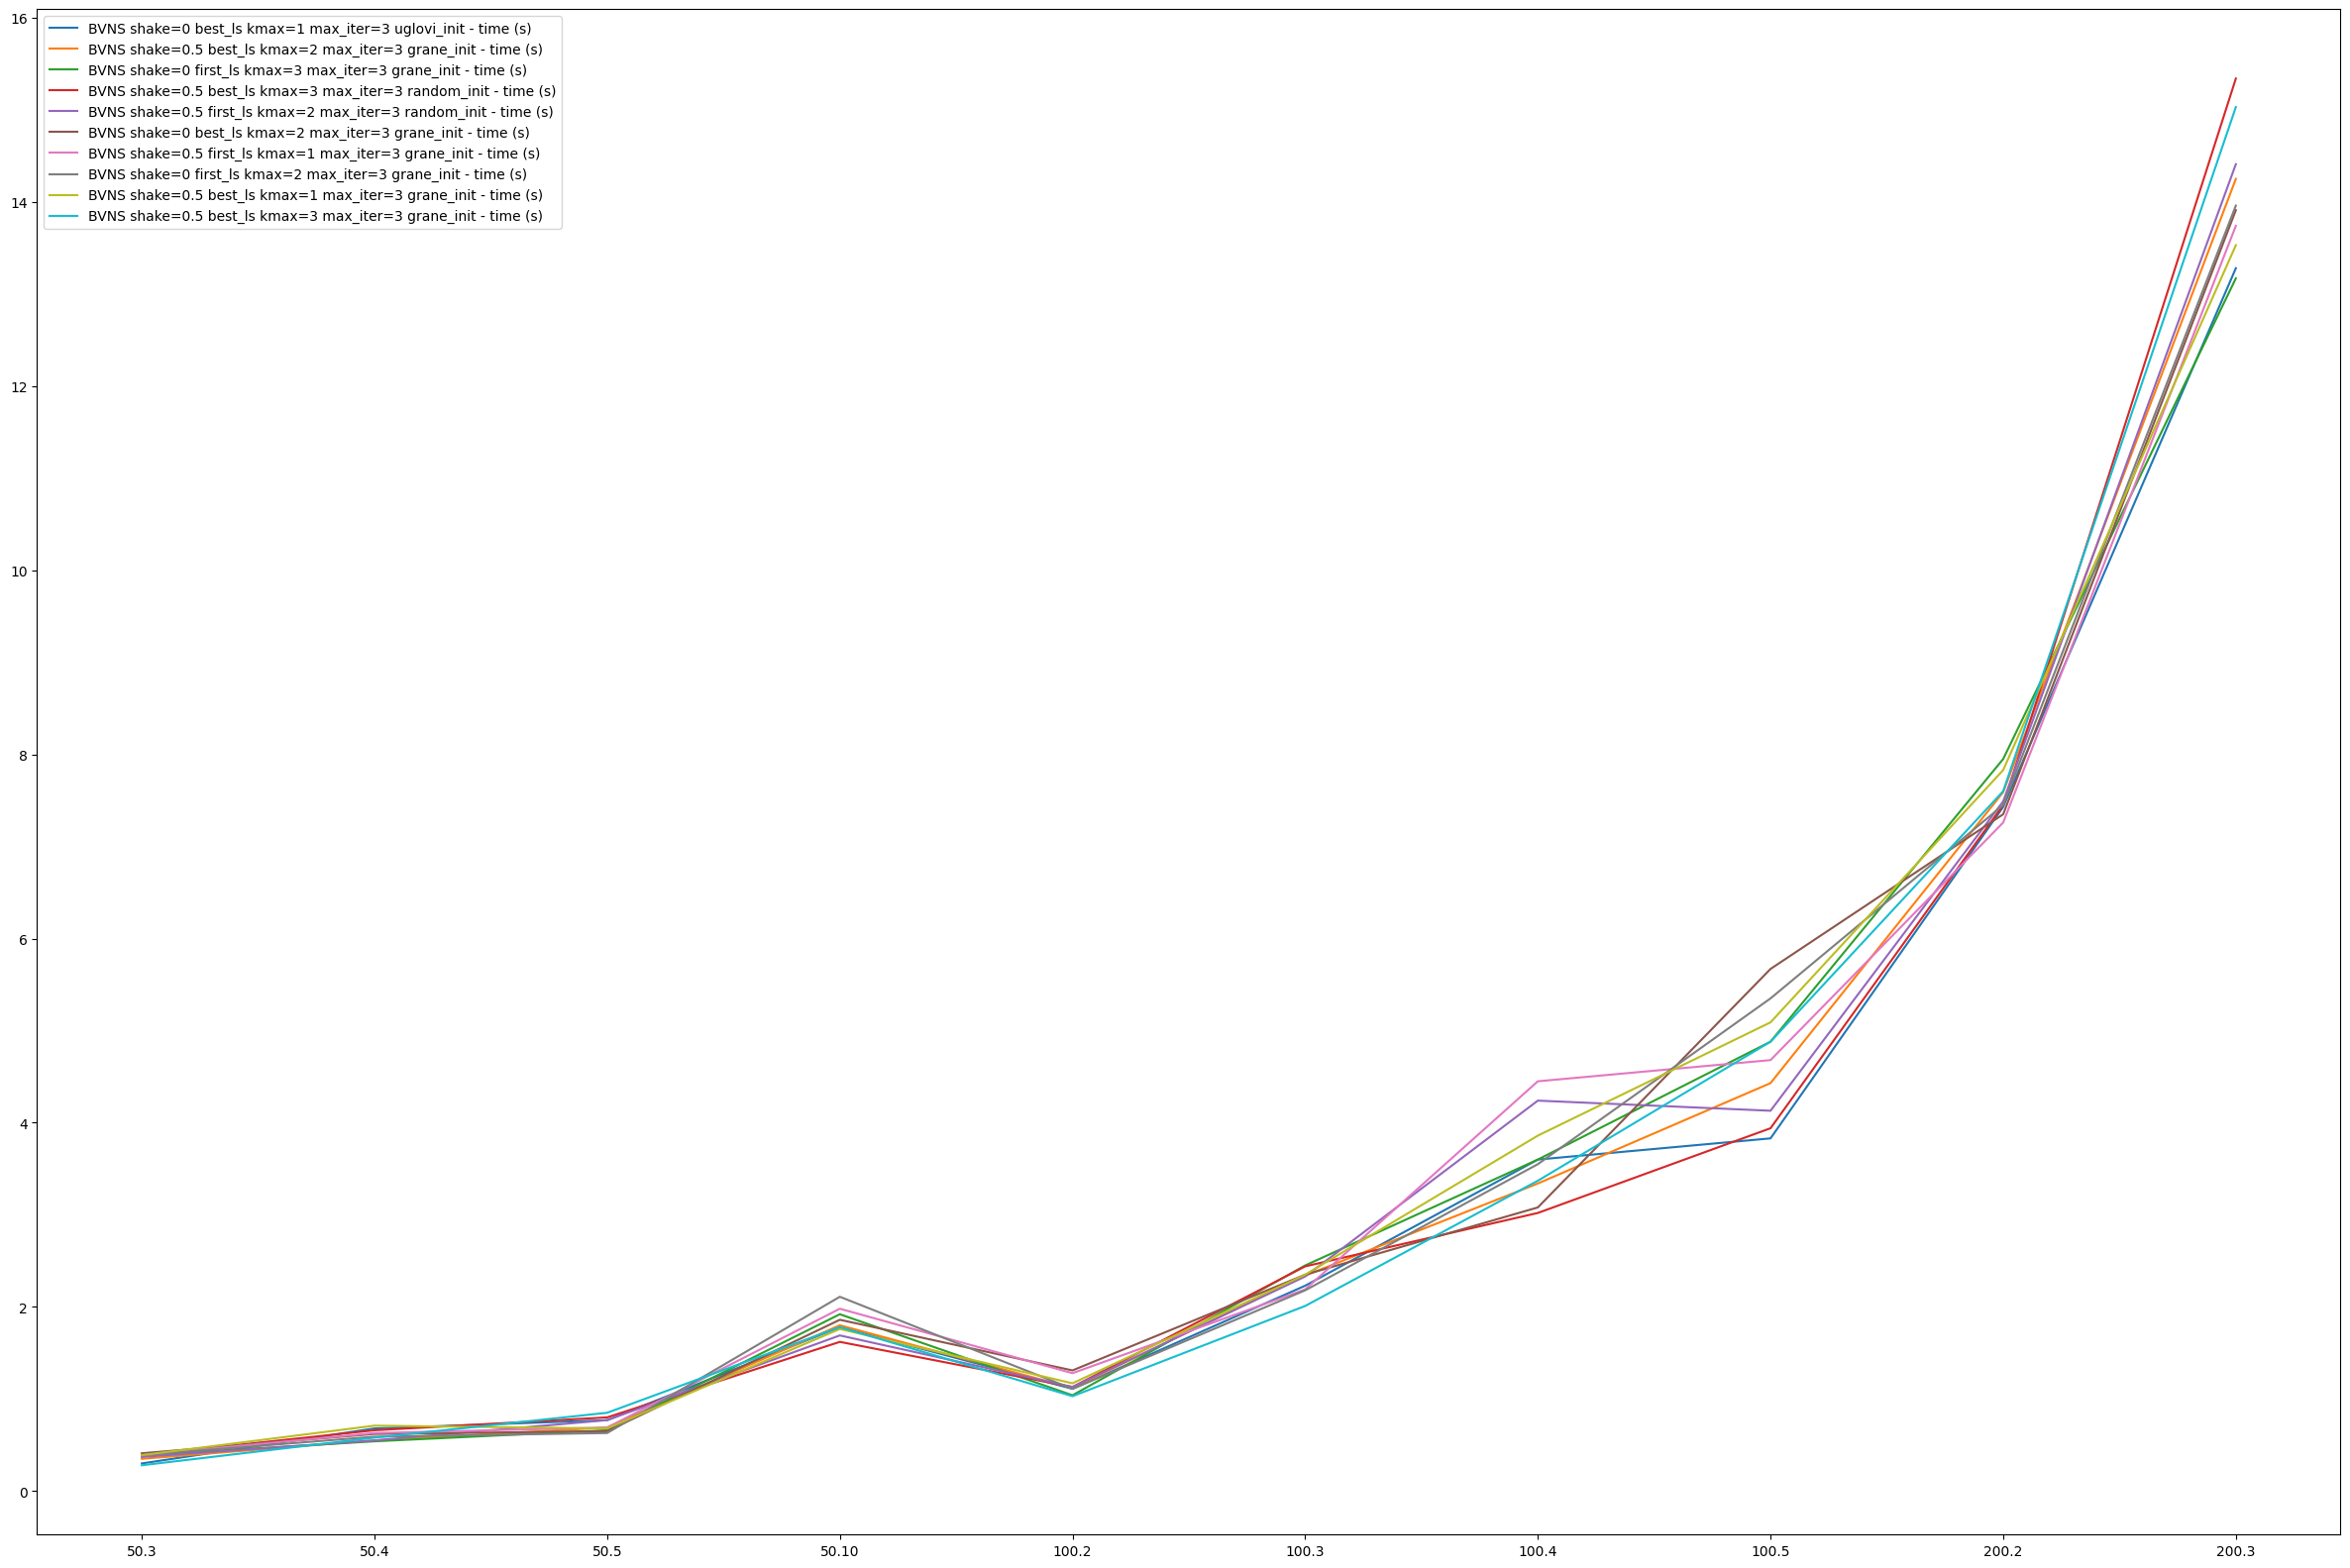

In [21]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(20)

for i in range(10):
    plt.plot(time_table.sort_values(by='mean', axis=1).iloc[18:-1, i], label=time_table.sort_values(by='mean', axis=1).columns[i])
    plt.legend()

In [22]:
deviation_table.sort_values(by='mean', axis=1).iloc[:, : 10]

,BVNS shake=0 first_ls kmax=3 max_iter=3 uglovi_init - deviation (%),BVNS shake=0.5 first_ls kmax=1 max_iter=3 uglovi_init - deviation (%),BVNS shake=0.5 best_ls kmax=3 max_iter=3 uglovi_init - deviation (%),BVNS shake=0 best_ls kmax=2 max_iter=3 uglovi_init - deviation (%),BVNS shake=0 best_ls kmax=3 max_iter=3 random_init - deviation (%),BVNS shake=0.5 best_ls kmax=2 max_iter=3 grane_init - deviation (%),BVNS shake=0 first_ls kmax=1 max_iter=3 random_init - deviation (%),BVNS shake=0 first_ls kmax=3 max_iter=3 random_init - deviation (%),BVNS shake=0.5 first_ls kmax=2 max_iter=3 uglovi_init - deviation (%),BVNS shake=0.5 best_ls kmax=3 max_iter=3 random_init - deviation (%)
10.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
20.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
20.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
20.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
20.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
